# Import Liberaries

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import re
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from collections import Counter
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Connect My  Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read Data 

Two files on file contain three emotions ('anger', 'joy', 'sadness')
and another file contain 'Neutral' emotion 

First file 

data link : https://public.tableau.com/app/profile/saif2522/viz/EmoInt-web2/EmotionIntensityDashboard

In [ ]:
data_1=pd.read_csv('drive/My Drive/CORELIA/Gantt_Bars_Full_Data_data.csv')
data_1=data_1.loc[:,['Emotion','Tweet']]
data_1.head()

,Emotion,Tweet
0,anger,-- haired man strides close and watches as the...
1,anger,.@LEAFYSZERKER @markiplier is that an insult? ...
2,anger,.@RepDelBene: 'Today's proceedings and the ent...
3,anger,“Do not fret if you are not cool! Humans who f...
4,anger,{Strong hands moving to firmly grope each of @...


In [ ]:
data_1['Emotion'].unique()

array(['anger', 'joy', 'sadness'], dtype=object)

In [ ]:
data_1['Emotion'].value_counts()

anger      1701
joy        1611
sadness    1533
Name: Emotion, dtype: int64

Secand file

data link : https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets?select=processedNeutral.csv

In [ ]:
data_2=pd.read_csv('drive/My Drive/CORELIA/processedNeutral.csv',squeeze=True).T.reset_index()
data_2['Emotion']=['Neutral']*len(data_2)
data_2.columns=['Tweet','Emotion']
data_2.head()

,Tweet,Emotion
0,Pak PM survives removal scare,Neutral
1,but court orders further probe into corruptio...,Neutral
2,Supreme Court quashes criminal complaint again...,Neutral
3,Art of Living's fights back over Yamuna floodp...,Neutral
4,livid.,Neutral


Combine two files  

In [ ]:
data = pd.concat([data_1,data_2],axis=0)

In [ ]:
data.head()

,Emotion,Tweet
0,anger,-- haired man strides close and watches as the...
1,anger,.@LEAFYSZERKER @markiplier is that an insult? ...
2,anger,.@RepDelBene: 'Today's proceedings and the ent...
3,anger,“Do not fret if you are not cool! Humans who f...
4,anger,{Strong hands moving to firmly grope each of @...


shuffle dataframe raws


In [ ]:
data=data.sample(frac = 1)
data.head()

,Emotion,Tweet
571,anger,Did we miss the fact that #BurkeRamsey swung &...
1447,sadness,@10carley what a sulky pants!
4660,anger,@JaredWyand Maybe if it was transgender the me...
806,joy,@FOXTV did you use the warblers set from glee ...
4145,sadness,Special thanks to @hamsterwatch &amp; @UgotBro...


In [ ]:
data['Emotion'].unique()

array(['anger', 'sadness', 'joy', 'Neutral'], dtype=object)

# Preprocessing

check data balancing 

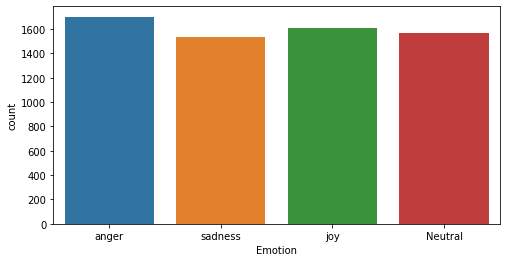

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x=data['Emotion'])
plt.show()

according figure above --  > data is balance

In [ ]:
#converte emotions to number
emotions={'Neutral':0,'joy':1,'sadness':2,'anger':3}
def get_emotion_class(emotion):
    return emotions[emotion]

In [ ]:
for i in range(4):
    print(data.iloc[i,0]," : ",get_emotion_class(data.iloc[i,0]))

anger  :  3
sadness  :  2
anger  :  3
joy  :  1


In [ ]:
data['Emotion']=data['Emotion'].apply(get_emotion_class)
data.head()

,Emotion,Tweet
571,3,Did we miss the fact that #BurkeRamsey swung &...
1447,2,@10carley what a sulky pants!
4660,3,@JaredWyand Maybe if it was transgender the me...
806,1,@FOXTV did you use the warblers set from glee ...
4145,2,Special thanks to @hamsterwatch &amp; @UgotBro...


Example Of Preprocessing On One Senetance

In [ ]:
# Clean sentance
sentance = data.iloc[0,1]
print(sentance)
sentance=re.sub(r'#[a-zA-Z0-9|_]+','',sentance) # remove hashtage 
sentance=re.sub(r'@[a-zA-Z0-9|_]+','',sentance) # remove @userName
sentance=re.sub(r'RT[\s]+',' ',sentance) #removing retweets
#text=re.sub(r'_','',text) #removing retweets
sentance=re.sub(r'https?:\/\/\S+',' ',sentance) #removing hyperlinks
sentance=re.sub(r'\W',' ',sentance) #removing special characters
sentance=re.sub(r'\d',' ',sentance) #removing special characters
sentance=re.sub(r'(^\s+)','',sentance)
sentance=re.sub(r'(\s+$)','',sentance)
sentance=sentance.lower()
sentance

Did we miss the fact that #BurkeRamsey swung &amp;hit his sister #JonBenet in the face with a golf club previously out of a fit of ?


'did we miss the fact that  swung  amp hit his sister  in the face with a golf club previously out of a fit of'

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
sentance=sentance.split()
sentance_clean=[]
post=''
ps = PorterStemmer()
for token in sentance:
    if len(token) > 2 and token not in string.punctuation and token.lower() not in stop_words:
        word=ps.stem(token) 
        sentance_clean.append(word)
        

In [ ]:
sentance_clean=' ' .join(sentance_clean)
print(data.iloc[0,1])
sentance_clean

Did we miss the fact that #BurkeRamsey swung &amp;hit his sister #JonBenet in the face with a golf club previously out of a fit of ?


'miss fact swung amp hit sister face golf club previous fit'

Buid process sentances method 

In [ ]:
def cleanText(text):
    text=re.sub(r'#[a-zA-Z0-9|_]+','',text) # remove hashtage 
    text=re.sub(r'@[a-zA-Z0-9|_]+','',text) # remove @userName
    text=re.sub(r'RT[\s]+',' ',text) #removing retweets
    text=re.sub(r'https?:\/\/\S+',' ',text) #removing hyperlinks
    text=re.sub(r'\W',' ',text) #removing special characters
    text=re.sub(r'\d',' ',text) #removing special characters
    text=re.sub(r'(^\s+)','',text)  # removing space in front text 
    text=re.sub(r'(\s+$)','',text) # removing space in tail text 
    return text

In [ ]:
def process_sentance(sentance):
    # Clean sentance
    sentance=cleanText(sentance)
    #tokenization
    sentance=sentance.split()
    #Remove Stopwords
    sentance=[token for token in sentance if len(token) > 2  and token not in stop_words]
    #Stemming
    ps = PorterStemmer()
    sentance=[ps.stem(word) for word in  sentance]
    sentance=' ' .join(sentance)
    return sentance

data before process

In [ ]:
for i in range(5):
    print(data.iloc[i,1])

Did we miss the fact that #BurkeRamsey swung &amp;hit his sister #JonBenet in the face with a golf club previously out of a fit of ?
@10carley what a sulky pants!
@JaredWyand Maybe if it was transgender the media would cover it #outrage
@FOXTV did you use the warblers set from glee on the @BONESonFOX episode about the acapella college kids?
Special thanks to @hamsterwatch &amp; @UgotBronx for keeping us updated &amp; entertained this dismal BB season 💕


In [ ]:
data['Tweet']=data['Tweet'].apply(process_sentance)

data after processing 

In [ ]:
for i in range(5):
    print(data.iloc[i,1])

did miss fact swung amp hit sister face golf club previous fit
sulki pant
mayb transgend media would cover
use warbler set glee episod acapella colleg kid
special thank amp keep updat amp entertain dismal season


#  Validation 

We'll create five `Counter` objects, one for words from anger posts, one for words from sad posts,words from happy posts, words from Neutral posts,and one for all the words.

In [ ]:
# Create five Counter objects to store anger, happy,sad,Neutral and total counts
anger_counts = Counter()
happy_counts = Counter()
sad_counts = Counter()
natural_counts = Counter()
total_counts = Counter()

Examine all the posts. For each word in a angur post, increase the count for that word in both  angur counter and the total words counter; likewise, for each word in a sad,Neutral,happy posts, increase the count for that word in both  sad,Neutral,happy counter and the total words counter.

In [ ]:
# Loop over all the words in all the posts and increment the counts in the appropriate counter objects
for i in range(len(data)):
    if(data.iloc[i,0] == 0):#Neutral
        for word in data.iloc[i,1].split(" "):
            natural_counts[word] += 1
            total_counts[word] += 1
    elif (data.iloc[i,0] == 2): #sad
        for word in data.iloc[i,1].split(" "):
                sad_counts[word] += 1
                total_counts[word] += 1
    elif (data.iloc[i,0] == 1):#happy
        for word in data.iloc[i,1].split(" "):
                happy_counts[word] += 1
                total_counts[word] += 1
    else:                      #angur
        for word in data.iloc[i,1].split(" "):
                anger_counts[word] += 1
                total_counts[word] += 1


In [ ]:
# Examine the counts of the most common words in happy posts
happy_counts.most_common()

[('cheer', 129),
 ('day', 110),
 ('watch', 110),
 ('love', 108),
 ('happi', 108),
 ('live', 106),
 ('make', 104),
 ('amp', 102),
 ('good', 84),
 ('smile', 84),
 ('like', 83),
 ('get', 81),
 ('the', 71),
 ('amaz', 66),
 ('time', 62),
 ('see', 61),
 ('rejoic', 61),
 ('feel', 59),
 ('look', 57),
 ('one', 55),
 ('broadcast', 55),
 ('know', 54),
 ('thank', 50),
 ('play', 49),
 ('exhilar', 49),
 ('you', 49),
 ('alway', 48),
 ('want', 47),
 ('life', 46),
 ('joy', 46),
 ('today', 44),
 ('new', 44),
 ('much', 44),
 ('need', 43),
 ('pleas', 43),
 ('laughter', 39),
 ('glee', 37),
 ('way', 37),
 ('peopl', 37),
 ('thing', 37),
 ('still', 36),
 ('back', 36),
 ('got', 36),
 ('anim', 34),
 ('hilari', 33),
 ('elat', 33),
 ('think', 33),
 ('give', 33),
 ('come', 32),
 ('would', 32),
 ('optim', 32),
 ('delight', 32),
 ('great', 31),
 ('cheeri', 30),
 ('hilar', 30),
 ('sparkl', 30),
 ('laugh', 30),
 ('thi', 30),
 ('hearti', 29),
 ('best', 29),
 ('never', 29),
 ('man', 29),
 ('say', 29),
 ('breezi', 29),
 

In [ ]:
# Examine the counts of the most common words in anger posts
anger_counts.most_common()

[('like', 140),
 ('get', 130),
 ('peopl', 98),
 ('one', 78),
 ('amp', 71),
 ('rage', 71),
 ('offend', 68),
 ('make', 62),
 ('fuck', 62),
 ('think', 56),
 ('got', 54),
 ('know', 53),
 ('take', 51),
 ('want', 50),
 ('anger', 50),
 ('time', 50),
 ('need', 49),
 ('the', 47),
 ('look', 46),
 ('say', 46),
 ('see', 44),
 ('love', 43),
 ('someon', 41),
 ('never', 41),
 ('you', 41),
 ('burn', 41),
 ('even', 41),
 ('lol', 40),
 ('realli', 40),
 ('angri', 40),
 ('black', 39),
 ('back', 39),
 ('today', 39),
 ('irrit', 38),
 ('would', 37),
 ('snap', 37),
 ('fume', 36),
 ('feel', 36),
 ('day', 35),
 ('watch', 35),
 ('outrag', 35),
 ('play', 34),
 ('man', 34),
 ('go', 34),
 ('work', 34),
 ('offens', 33),
 ('still', 33),
 ('thing', 33),
 ('alway', 33),
 ('resent', 33),
 ('let', 32),
 ('sting', 32),
 ('furi', 32),
 ('boil', 31),
 ('pout', 31),
 ('right', 31),
 ('come', 31),
 ('reveng', 31),
 ('use', 31),
 ('madden', 31),
 ('insult', 30),
 ('good', 30),
 ('bitter', 30),
 ('hate', 30),
 ('furiou', 30),
 

In [ ]:
# Examine the counts of the most common words in Neutral posts
natural_counts.most_common()

[('also', 79),
 ('epap', 76),
 ('india', 72),
 ('court', 66),
 ('say', 61),
 ('govt', 52),
 ('how', 47),
 ('minist', 45),
 ('suprem', 40),
 ('whi', 33),
 ('case', 33),
 ('take', 32),
 ('', 30),
 ('get', 30),
 ('bjp', 27),
 ('chief', 26),
 ('bengal', 25),
 ('the', 24),
 ('calcutta', 24),
 ('after', 24),
 ('day', 23),
 ('what', 23),
 ('modi', 23),
 ('today', 23),
 ('order', 22),
 ('indian', 22),
 ('vote', 21),
 ('leader', 20),
 ('arrest', 20),
 ('elect', 20),
 ('attack', 20),
 ('meet', 20),
 ('want', 19),
 ('poll', 19),
 ('delhi', 19),
 ('call', 19),
 ('seat', 19),
 ('ban', 19),
 ('new', 19),
 ('polic', 18),
 ('live', 17),
 ('year', 17),
 ('ask', 17),
 ('state', 17),
 ('may', 16),
 ('governor', 16),
 ('death', 15),
 ('and', 15),
 ('parti', 15),
 ('back', 15),
 ('judg', 14),
 ('top', 14),
 ('law', 14),
 ('put', 13),
 ('plan', 13),
 ('trump', 13),
 ('rule', 13),
 ('bodi', 13),
 ('assembl', 13),
 ('give', 12),
 ('test', 12),
 ('plea', 12),
 ('end', 12),
 ('run', 12),
 ('name', 12),
 ('offic

In [ ]:
# Examine the counts of the most common words in sad posts
sad_counts.most_common()

[('get', 122),
 ('amp', 98),
 ('like', 93),
 ('depress', 90),
 ('sad', 82),
 ('know', 77),
 ('day', 74),
 ('feel', 73),
 ('time', 70),
 ('the', 69),
 ('one', 62),
 ('look', 60),
 ('see', 58),
 ('discourag', 53),
 ('love', 51),
 ('good', 49),
 ('want', 48),
 ('lost', 47),
 ('make', 47),
 ('play', 43),
 ('think', 42),
 ('peopl', 42),
 ('stay', 41),
 ('realli', 40),
 ('even', 39),
 ('let', 39),
 ('need', 39),
 ('thing', 39),
 ('got', 39),
 ('frown', 38),
 ('thi', 38),
 ('still', 37),
 ('blue', 37),
 ('sober', 36),
 ('would', 36),
 ('life', 36),
 ('work', 36),
 ('you', 36),
 ('someon', 35),
 ('today', 35),
 ('dark', 35),
 ('go', 34),
 ('week', 34),
 ('take', 34),
 ('alway', 32),
 ('way', 32),
 ('seriou', 31),
 ('dread', 31),
 ('grim', 31),
 ('new', 31),
 ('pout', 31),
 ('don', 31),
 ('mourn', 31),
 ('watch', 31),
 ('dull', 31),
 ('sink', 31),
 ('gloomi', 30),
 ('never', 30),
 ('pine', 30),
 ('unhappi', 30),
 ('sadli', 30),
 ('despair', 30),
 ('night', 29),
 ('happi', 29),
 ('tri', 29),
 ('

In [ ]:

total_counts.most_common()
list(reversed(total_counts.most_common()))[7000:7500]


[('dri', 13),
 ('assembl', 13),
 ('former', 13),
 ('list', 13),
 ('app', 13),
 ('kick', 13),
 ('met', 13),
 ('effect', 13),
 ('manag', 13),
 ('spend', 13),
 ('pessimist', 13),
 ('cant', 13),
 ('fast', 13),
 ('cours', 13),
 ('smh', 13),
 ('forget', 13),
 ('afflict', 13),
 ('deliv', 13),
 ('bank', 13),
 ('swear', 13),
 ('charact', 13),
 ('mirth', 13),
 ('behind', 13),
 ('pour', 13),
 ('memori', 13),
 ('score', 13),
 ('weak', 13),
 ('polici', 13),
 ('research', 13),
 ('sens', 13),
 ('matter', 13),
 ('gun', 13),
 ('social', 13),
 ('mom', 13),
 ('finish', 13),
 ('somebodi', 13),
 ('record', 13),
 ('journey', 13),
 ('nephew', 13),
 ('send', 13),
 ('hang', 13),
 ('account', 13),
 ('spent', 13),
 ('incens', 13),
 ('clean', 13),
 ('griev', 13),
 ('chanc', 13),
 ('piec', 13),
 ('seri', 13),
 ('major', 14),
 ('held', 14),
 ('perfect', 14),
 ('drive', 14),
 ('bitch', 14),
 ('onlin', 14),
 ('indign', 14),
 ('kinda', 14),
 ('truli', 14),
 ('shut', 14),
 ('forc', 14),
 ('student', 14),
 ('surpris', 1

### Create vectors for each Sentence


 #### Use Pre word embedding 

 TfidfVectorizer

In [ ]:
vectorizer=TfidfVectorizer(max_features=7000)
vectores=vectorizer.fit_transform(data.iloc[:,1].values).toarray()

In [ ]:
vectores.shape

(6415, 7000)

## Model 

I will use Machine Learning Algorithm (data not large enough to use deep learning model)

In [ ]:
y=data['Emotion'].values
#Split data to train and test 
train_X,test_X,train_y,test_y=train_test_split(vectores,y) # split 75% for train and  25% for test 

I used Random forest 


In [ ]:
model=RandomForestClassifier(n_estimators=100)

In [ ]:
#train Model 
model.fit(train_X,train_y)

RandomForestClassifier()

check model performance

In [ ]:
y_pred=model.predict(test_X)
print("Accuracy : ",round(accuracy_score(test_y,y_pred)*100,2),'%')

Accuracy :  82.73 %


define method to take list of post and resturn emotions for each post 

In [ ]:
emotions={0:'Neutral',1:'Happy',2:'Sad',3:'Anger'}
def posts_emotions_detect(posts):
    prediction=[]
    if type(posts)==list:
        for post in posts:
            post=process_sentance(post)
            x=vectorizer.transform([post])
            
            y_pred=model.predict(x)
            prediction.append(emotions[y_pred[0]])
    return prediction

example on prediction

In [ ]:
posts=['i am very happy','i am sad ',' i am anger']

prediction=posts_emotions_detect(posts)

In [ ]:
prediction

['Happy', 'Sad', 'Anger']

# Random Search for tuning hyperparameter of Random Forest

In [ ]:
parameters={
    'n_estimators':[150,200,250,300],
     'max_depth':[200,400,500,600],
    'min_samples_split':[2,4,6,8]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
model=RandomForestClassifier()
r_search=RandomizedSearchCV(model,param_distributions=parameters,cv=5,n_jobs=-1)
r_search.fit(train_X,train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [80, 100, 150, 200],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [150, 200, 250, 300]})

In [ ]:
print("Best Parameters ",r_search.best_params_)

Best Parameters  {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 200}


In [ ]:
model2=RandomForestClassifier(**r_search.best_params_)
model2.fit(train_X,train_y)

RandomForestClassifier(max_depth=200, n_estimators=300)

In [ ]:
y_pred=model2.predict(test_X)
print("Accuracy : ",round(accuracy_score(test_y,y_pred)*100,2),'%')

Accuracy :  82.73 %


Save My model 

In [ ]:
# save the model to disk
filename = 'drive/My Drive/CORELIA/emotion_model.sav'
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_X, test_y)


Use another Text Vectorization

OneHotEncoder

In [ ]:
#creating bag of words 
def vectorize(doc):
    return {
        token: True
        for token in doc
    }

vectors = map(vectorize, data.iloc[:,1].values)


In [ ]:
y=data['Emotion'].values
#Split data to train and test 
train_X,test_X,train_y,test_y=train_test_split(vectores,y) # split 75% for train and  25% for test 

model

In [ ]:
model2=RandomForestClassifier(n_estimators=100)
model2.fit(train_X,train_y)

RandomForestClassifier()

## check accuracy

In [ ]:
y_pred=model2.predict(test_X)
print("Accuracy : ",round(accuracy_score(test_y,y_pred)*100,2),'%')

Accuracy :  82.11 %


In [ ]:
def posts_emotions_detect(posts):
    prediction=[]
    if type(posts)==list:
        for post in posts:
            post=process_sentance(post)
            x=vectorizer.transform([post])
            
            y_pred=model2.predict(x)
            prediction.append(emotions[y_pred[0]])
    return prediction

In [ ]:
posts=['i am very happy','i am sad ',' i am anger']

prediction=posts_emotions_detect(posts)
print(prediction)

['Happy', 'Sad', 'Anger']


Best Model 

In [ ]:
# load the model from disk
filename = 'drive/My Drive/CORELIA/emotion_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_X, test_y)


Method for predict emotions

In [ ]:
def posts_emotions_detect(posts):
    prediction=[]
    if type(posts)==list:
        for post in posts:
            post=process_sentance(post)
            x=vectorizer.transform([post])
            
            y_pred=loaded_model.predict(x)
            prediction.append(emotions[y_pred[0]])
    return prediction

In [ ]:
emotions={0:'Neutral',1:'Happy',2:'Sad',3:'Anger'}

 ### Test Model 


In [ ]:
posts=["I took all my frustration and anger out on you.",
      "Dusty echoed, anger burning through him.",
      'Inside, he was burning with anger at the reminder.',     
      'Happy to meet you at last, Yully.',
      'I hope you two are happy together.',
      "I'd be happy knowing you're safe.",
      'She approached, a sad smile on her face.',
      'I suppose it would be a sad memory.',
      'We have a natural desire to want to help others.',
      'Alex was doing everything in his power to provide her with all the experiences of a natural mother.',
      'Even as she thought it, she knew her anger had nothing to do with their heritage.',]

Actual=['Anger','Anger','Anger','Happy','Happy','Happy','Sad','Sad','Neutral','Neutral','Anger']

In [ ]:
prediction=posts_emotions_detect(posts)


In [ ]:
print("Actual     : ",Actual)
print("Prediction : ",prediction)

Actual     :  ['Anger', 'Anger', 'Anger', 'Happy', 'Happy', 'Happy', 'Sad', 'Sad', 'Neutral', 'Neutral', 'Anger']
Prediction :  ['Anger', 'Anger', 'Anger', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Neutral', 'Sad', 'Anger']
